In [661]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
from math import pi
import itertools
import CUDAPython as CP
import time
from scipy.optimize import curve_fit
%matplotlib inline

In [274]:
#sets number of levels (k) and number of fermions (m)
k = 12
m = 6

In [662]:
k_b = 1.38064852*math.pow(10,-23)

DEFINING FUNCTIONS BELOW

In [275]:
def generate_energies(k):
    '''generates ordered array of k distinct energy levels'''
    energies = np.empty(k)
    count=0
    while(count!=k):
        energies[count]=normal(0,1) #samples a normal distribution k times
        count+=1
    return np.sort(energies) #output is a scaled, sorted array of size k

def size(k, m):
    '''determines the number of combination of m fermions on k energy levels'''
    return int(math.factorial(k)/((math.factorial(k-m))*(math.factorial(m))))

def ground_state(k, m):
    '''initialises a ground state based on number of fermions (m) and number of energy levels (k)
    
    e.g. for k=10, m=5:
    ground state is [1,1,1,1,1,0,0,0,0,0]'''
    state = np.zeros(k, dtype=int)
    for i in range(m):
        state[i] = 1
    return state

def permutations(state):
    '''returns a list of possible permutations of a given binary state'''
    return list(set(itertools.permutations(state)))   

def time_step(init_state, sigma_w):
    '''Determines the time step to compute the time evolution using the Fermi Golden Rule'''
    dt = 0
    if init_state==0:
        dE = D[init_state+1][init_state+1] - D[init_state][init_state]
    else:
        dE = D[init_state][init_state] - D[init_state-1][init_state-1]
    
    f = 2*pi*sigma_w**2*(1/dE) #fermi golden rule (approximation)
    
    return 1/(f*10)

#need time evolution of the D matrix
def D_evo(dt):
    '''Function that produces the D matrix for a given time t (time evolution of D matrix)'''
    D_ev = np.zeros((size(k,m), size(k,m)), dtype=complex)
    
    for x in range(size(k,m)):
        D_ev[x][x] = np.exp(-1j*D[x][x]*dt) #calculates time evolution of the diagonal elements, removed factor of 1/hbar
    return D_ev

def V_t(dt):
    '''Evolution operator at time interval dt'''
    D_exp = D_evo(dt) #evolution matrix for a time t
    left_mat = np.matmul(P, D_exp) #multiplying P*e^D
    return np.matmul(left_mat, P_T) #multiplying above by P_T

In [276]:
def next_state(V_t, state):
    return np.matmul(V_t, state)

In [277]:
def coefs(state):
    state_conj = np.conj(state)
    coefficients = np.empty(size(k,m))
    
    for i in range(size(k,m)):
        coefficients[i] = (np.dot(state[i], state_conj[i])).real
    return coefficients

In [278]:
def occupation_number(state, lev):
    _sum=0
    coef = coefs(state)
    
    for i in range(size(k,m)):
        _sum += coef[i]*i_state_map[i][lev]
    return _sum

In [553]:
def plot_init_state(energies, state):
    '''Function that displays a plot of a given state'''
    fig, axes = plt.subplots(figsize=((5,12)))
    
    axes.hlines(energies,0,1,'r', zorder=1, label='Energy level')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==1], color='b', zorder=2, label='Occupied state')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==0], color='b', facecolor='none',  zorder=2, label='Empty state')
  
    axes.spines['bottom'].set_color('none')
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.set_xticks([])
    axes.set_yticks(energies)
    axes.set_ylabel('Energy eigenvalue')
    axes.legend()
    fig.savefig("state")
    return

In [280]:
def run_simulation(runs):
    '''
    Function that runs the simulation 'runs' times and calculate the average occupation number per orbital as a function of time.
    Results are stored in a dictionary.
    '''
    s = np.zeros(size(k,m))

    s[init_state] = 1

    t = np.empty(runs)
    k0 = np.empty(runs)
    k1 = np.empty(runs)
    k2 = np.empty(runs)
    k3 = np.empty(runs)
    k4 = np.empty(runs)
    k5 = np.empty(runs)
    k6 = np.empty(runs)
    k7 = np.empty(runs)
    k8 = np.empty(runs)
    k9 = np.empty(runs)
    k10 = np.empty(runs)
    k11 = np.empty(runs)
    dt = time_step(init_state, sigma_w)

    for i in range(runs):
        t[i] = dt*i

        if i==0:
            k0[i] = occupation_number(s, 0)
            k1[i] = occupation_number(s, 1)
            k2[i] = occupation_number(s, 2)
            k3[i] = occupation_number(s, 3)
            k4[i] = occupation_number(s, 4)
            k5[i] = occupation_number(s, 5)
            k6[i] = occupation_number(s, 6)
            k7[i] = occupation_number(s, 7)
            k8[i] = occupation_number(s, 8)
            k9[i] = occupation_number(s, 9)
            k10[i] = occupation_number(s, 10)
            k11[i] = occupation_number(s, 11)
        else:
            s = next_state(V_t(dt), s)
            k0[i] = occupation_number(s, 0)
            k1[i] = occupation_number(s, 1)
            k2[i] = occupation_number(s, 2)
            k3[i] = occupation_number(s, 3)
            k4[i] = occupation_number(s, 4)
            k5[i] = occupation_number(s, 5)
            k6[i] = occupation_number(s, 6)
            k7[i] = occupation_number(s, 7)
            k8[i] = occupation_number(s, 8)
            k9[i] = occupation_number(s, 9)
            k10[i] = occupation_number(s, 10)
            k11[i] = occupation_number(s, 11)

    return {'t':t, 'k0':k0, 'k1':k1, 'k2':k2, 'k3':k3, 'k4':k4, 'k5':k5,'k6':k6, 'k7':k7, 'k8':k8, 'k9':k9, 'k10':k10, 'k11':k11}

In [765]:
def plot_occupation_time(data, cut_off, filename):
    
    fig, axes = plt.subplots(figsize=((10,6)))
    
    axes.plot(data['t'][cut_off:],data['k0'][cut_off:], label='k = 0')
    axes.plot(data['t'][cut_off:],data['k1'][cut_off:], label='k = 1')
    axes.plot(data['t'][cut_off:],data['k2'][cut_off:], label='k = 2')
    axes.plot(data['t'][cut_off:],data['k3'][cut_off:], label='k = 3')
    axes.plot(data['t'][cut_off:],data['k4'][cut_off:], label='k = 4')
    axes.plot(data['t'][cut_off:],data['k5'][cut_off:], label='k = 5')
    axes.plot(data['t'][cut_off:],data['k6'][cut_off:], label='k = 6')
    axes.plot(data['t'][cut_off:],data['k7'][cut_off:], label='k = 7')
    axes.plot(data['t'][cut_off:],data['k8'][cut_off:], label='k = 8')
    axes.plot(data['t'][cut_off:],data['k9'][cut_off:], label='k = 9')
    axes.plot(data['t'][cut_off:],data['k10'][cut_off:], label='k = 10')
    axes.plot(data['t'][cut_off:],data['k11'][cut_off:], label='k = 11')
    axes.set_ylim((-0.01,1.01))
    axes.set_xlim((data['t'][cut_off],data['t'][-1]))
    axes.set_xlabel("Time, t", fontsize=15)
    axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$", fontsize=15)
    #axes.set_title(f"Evolution of state {init_state} with $\sigma$ = {sigma_w}")
    axes.legend(loc='upper center')
    fig.savefig(filename)
    return 

In [732]:
def plot_occupation_energy(data, cut_off, filename):
    '''
    Function that plots the mean occupation number per orbital, as a function of energy.
    '''
    mean = [np.mean(data['k{}'.format(i)][cut_off:]) for i in range(12)]

    fig, axes = plt.subplots(figsize=((20,10)))
    axes.scatter(random_energies_2,mean,color='red',marker='x')
    axes.set_ylim((-0.01,1.01))
    axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$")
    axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$")
    axes.set_xticks(random_energies_2)
    fig.savefig(filename) 
    return

In [620]:
def f(x, a, b, r):
    return ((a-b)*np.exp(-r*x))+(b*np.exp(-(r**2)*(x**2)))

In [767]:
def fermi_func(x, b, u):
    return 1/(np.exp((x-u)*b)+1)

In [549]:
random_energies_2 = np.array([-1.70302794, -1.24546591, -1.06902383, -0.92968048, -0.29326763,
       -0.10477327,  0.28222121,  0.47628504,  0.79509365,  1.03127604,
        1.19731455,  1.82563945])

In [550]:
random_energies_2

array([-1.70302794, -1.24546591, -1.06902383, -0.92968048, -0.29326763,
       -0.10477327,  0.28222121,  0.47628504,  0.79509365,  1.03127604,
        1.19731455,  1.82563945])

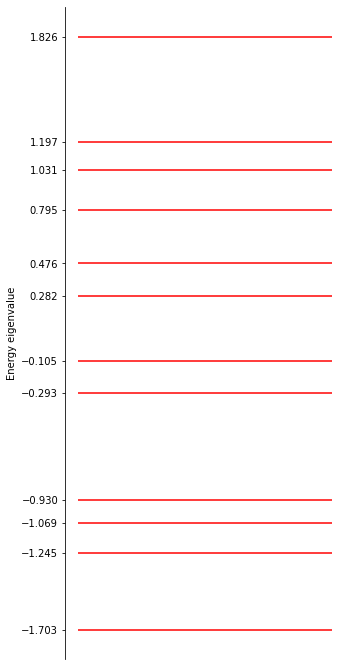

In [552]:
plot_init_state(random_energies_2)

In [556]:
state = ground_state(k, m) #initialises ground state

In [557]:
state

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [558]:
start = time.time()
states = permutations(state) #list of possible permutations of the ground state
print('Runtime: ', time.time()-start)

Runtime:  151.39147543907166


In [559]:
energy_state = {} #empty dict for mapping energies to their corresponding state {energy: state}
energies = np.empty(size(k,m))

In [560]:
for state in range(len(states)): #looping through all possible states
    energy = np.dot(states[state],random_energies_2) #computes energy of a given state via a dot product; energy and state arrays can be thought of as vectors -> dot product
    energies[state] = energy
    energy_state[energy] = states[state] #mapping the energy to its given state

In [561]:
sorted_energies = np.sort(energies) #sorting the energies in ascending order

sorted_dict = {} #empty dict to be used in mapping SORTED energies to their states (useful later)

In [562]:
for energy in sorted_energies:
    sorted_dict[energy] = energy_state[energy] #mapping sorted energies to their corresponding states

In [563]:
#need to map i to its corresponding state
i_state_map = {}
sorted_states = list(sorted_dict.values())

In [564]:
for i in range(size(k,m)):
    i_state_map[i] = sorted_states[i] #looping through all states and adding them to a dictionary i: state_i

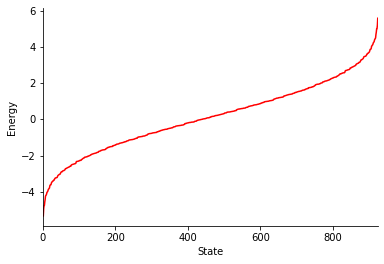

In [565]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size(k,m),size(k,m)),sorted_energies, 'red')
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy')
axes.set_xlim((0,size(k,m)))
fig.savefig("h_0")

In [611]:
sigma_w = 0.05
init_state = 0

In [612]:
start = time.time()

H_0 = np.zeros((size(k,m),size(k,m))) #generating a zero matrix which has dimensions of the number of permutations of the initial state

for i in range(size(k,m)):
    H_0[i][i] = sorted_energies[i] #filling the diagonals with the energy eigenvalues

w = np.empty((size(k,m),size(k,m))) #generating an empty matrix with the same dimensions as H_0

for i in range(size(k,m)):
    for j in range(size(k,m)):
        w[i][j] = normal(0,sigma_w) #loops through all possible elements of w and samples a normal distribution, can change variance sigma_w to change strength of interactions

w_T = np.transpose(w) #determines the transpose of the matrix w

W = (w+w_T)/2 #ensuring that the random matrix W is real and symmetric

H = H_0 + W #H is the hamiltonian with interactions due to the random matrix (non-diagonal)

#Diagonalisation of H:

hCUDA = CP.CUDAContext() #obtain CUDA context (only 1 needed)

hCUBLAS = CP.CUBLASContext() 
hCUBLAS.Create() #create CUBLAS context (for basic linear algebra ops)

hCUSolverDense = CP.CUSolverDenseContext()
hCUSolverDense.Create() #create CUSolver Context (for dense matrix ops)

#allocating memory on the CPU to fit a matrix of size size X size
hHostMatrix = CP.CUDAHostMemory()
hHostMatrix.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

hHostVector = CP.CUDAHostMemory()
hHostVector.Allocate1D(CP.CUDANumericSizeRD, size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

for i in range(size(k,m)):
    for j in range(size(k,m)):
        hHostMatrix.WriteRD(CP.CUDAMemoryPosition(i,j,0), H[i][j]) #initialising values

#allocating memory on the GPU to fit a matrix of size size X size
hDeviceMatrixA = CP.CUDADeviceMemory()
hDeviceMatrixA.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m))

hDeviceVectorX = CP.CUDADeviceMemory()
hDeviceVectorX.Allocate1D(CP.CUDANumericSizeRD, size(k,m))

hCUBLAS.SetMatrix(hDeviceMatrixA, CP.CUDAMemoryPosition(), hHostMatrix, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m),size(k,m),1)) #copy memory from CPU to GPU
hCUDA.WaitForCurrentDevice() #sync

#build and setup of solver
hEigenSolver = CP.CUSolverDenseEigenValue(hCUSolverDense)
hEigenSolver.SetMatrixA(hDeviceMatrixA)
hEigenSolver.SetMatrixFillModeA(CP.CUBLASContextFillMode.UPPER)
hEigenSolver.SetVectorX(hDeviceVectorX)
hEigenSolver.SetAlgorithm(CP.CUSolverDenseEigenValueAlgorithm.QR) #householder reduction method???
hEigenSolver.ComputeEigenVectors(True)

hEigenSolver.PrepareRD() #allocates workspace memory

#solve and sync
hEigenSolver.SolveRD()
hCUDA.WaitForCurrentDevice()
hEigenSolver.UpdateStateAfterSync()

#copy memory from GPU to CPU
hCUBLAS.GetMatrix(hHostMatrix, CP.CUDAMemoryPosition(), hDeviceMatrixA, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), size(k,m), 1))
hCUDA.WaitForCurrentDevice()

hCUBLAS.GetVector(hHostVector, CP.CUDAMemoryPosition(), hDeviceVectorX, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), 1, 1))
hCUDA.WaitForCurrentDevice()

hPos = CP.CUDAMemoryPosition()

D = np.zeros((size(k,m), size(k,m))) #initialising matrix to be used to store the eigenvalues as diagonal elements
P = np.zeros((size(k,m), size(k,m))) #initialising basis change matrix (H=PDP^-1)

for hPos.iX in range(size(k,m)):
    D[hPos.iX][hPos.iX] = hHostVector.ReadRD(hPos) #sets the diagonal elements of the matrix to the eigenvalues computed using the above algorithm

#need to prepare P matrix using the eigenvectors given by the above algorithm
for hPos.iY in range(size(k,m)):
    for hPos.iX in range(size(k,m)):
        P[hPos.iY][hPos.iX] = hHostMatrix.ReadRD(hPos)

P_T = np.transpose(P)

#free memory and destroy contexts
hDeviceVectorX.Free()
hDeviceMatrixA.Free()
hHostVector.Free()
hHostMatrix.Free()

hCUSolverDense.Destroy()
hCUBLAS.Destroy()

print('Runtime: ', time.time()-start)

Runtime:  7.655407190322876


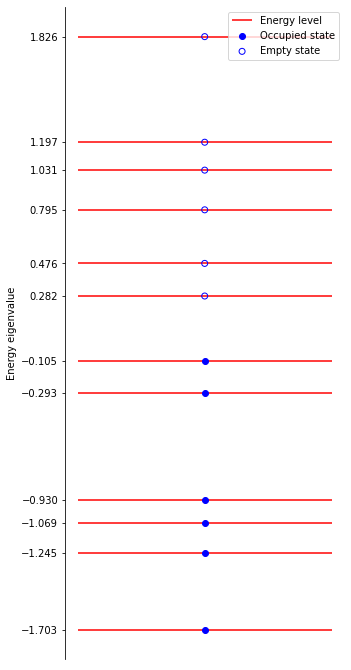

In [568]:
state = sorted_states[init_state]

state

plot_init_state(random_energies_2, state)

In [569]:
start = time.time()
dic_sigma_1_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.4044497013092


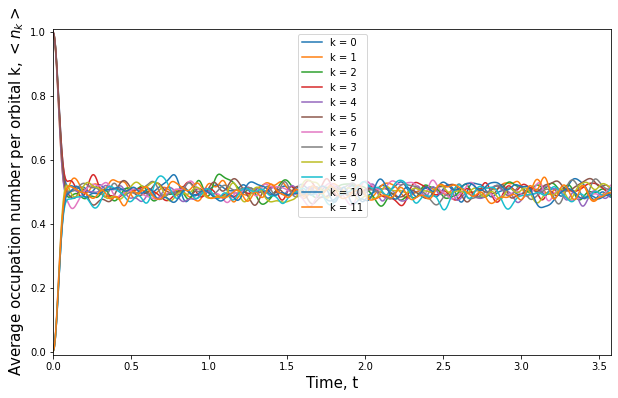

In [766]:
plot_occupation_time(dic_sigma_1_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format(1,500,0))

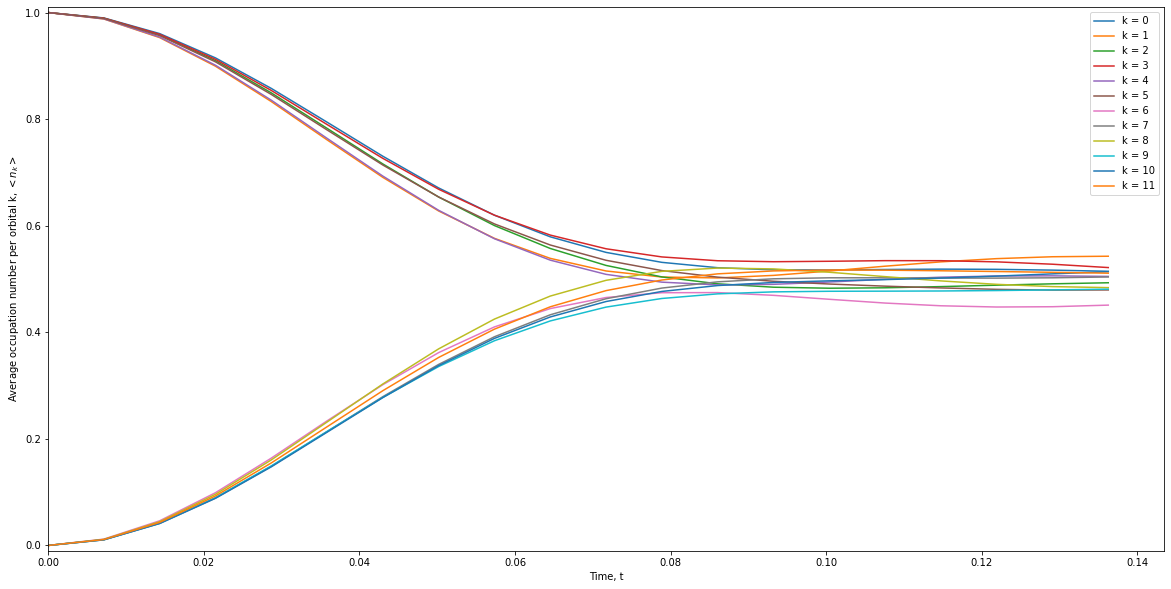

In [619]:
plot_occupation_time(dic_sigma_1_runs_500, 0, 20, 'transient_{}_runs_{}_cutoff_{}'.format(1,500,0))

[0.511057064512926,
 0.5115517678377186,
 0.5074014456611042,
 0.5079930484179324,
 0.5019740157165699,
 0.5077309507667009,
 0.4932337952613855,
 0.49680796020545864,
 0.4936331650043135,
 0.48669019409684355,
 0.4917998119969777,
 0.490126780526388]

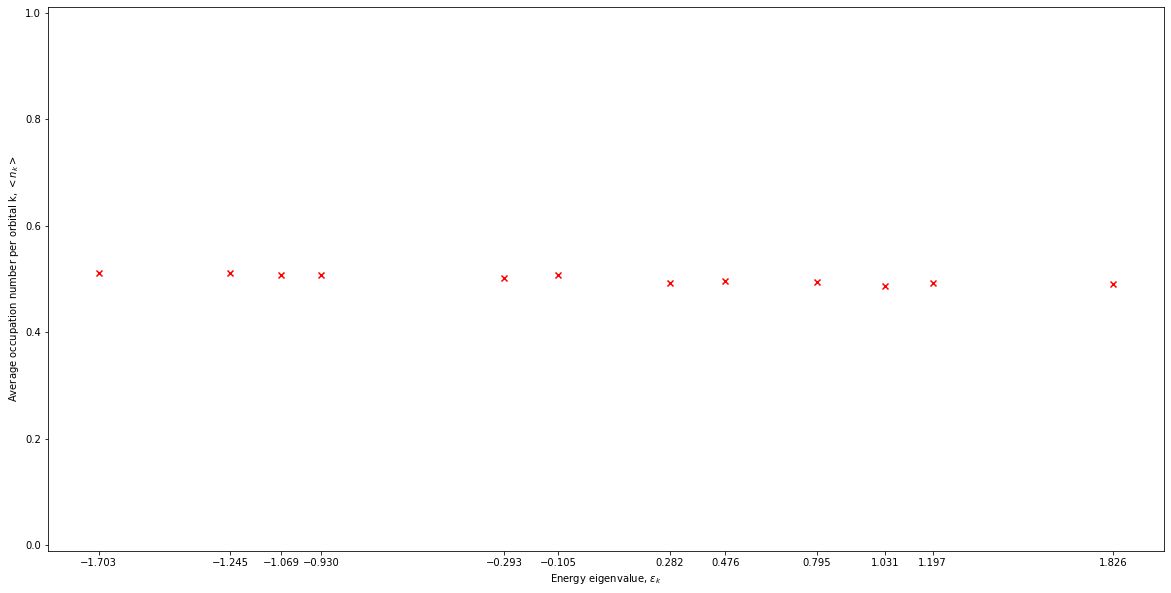

In [628]:
plot_occupation_energy(dic_sigma_1_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format(1,500,0))

In [768]:
popt, pcov = curve_fit(f, dic_sigma_1_runs_500['t'][0:20], dic_sigma_1_runs_500['k1'][0:20])

In [769]:
popt

array([ 1.04992926, -0.72444382,  5.40519309])

In [624]:
1/popt[-1]

0.18500726679737858

In [770]:
mean_1 = np.array([0.511057064512926,
 0.5115517678377186,
 0.5074014456611042,
 0.5079930484179324,
 0.5019740157165699,
 0.5077309507667009,
 0.4932337952613855,
 0.49680796020545864,
 0.4936331650043135,
 0.48669019409684355,
 0.4917998119969777,
 0.490126780526388])

In [641]:
random_energies_2

array([-1.70302794, -1.24546591, -1.06902383, -0.92968048, -0.29326763,
       -0.10477327,  0.28222121,  0.47628504,  0.79509365,  1.03127604,
        1.19731455,  1.82563945])

In [796]:
popt, pcov = curve_fit(fermi_func, random_energies_2, mean_1)

In [797]:
popt

array([0.03004287, 0.02187411])

In [773]:
range = np.linspace(-2, 2,500)

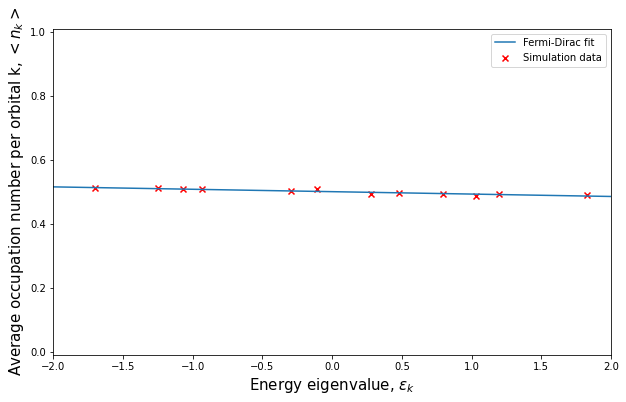

In [775]:
fig, axes = plt.subplots(figsize=((10,6)))
axes.scatter(random_energies_2,mean_1,color='red',marker='x', label='Simulation data')
axes.plot(range, fermi_func(range, *popt), label='Fermi-Dirac fit')
axes.set_ylim((-0.01,1.01))
axes.set_xlim((-2,2))
axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$", fontsize=15)
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$", fontsize=15)
axes.legend()
fig.savefig("occupation_time_fermi_1")

In [578]:
start = time.time()
dic_sigma_0_1_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  63.97180724143982


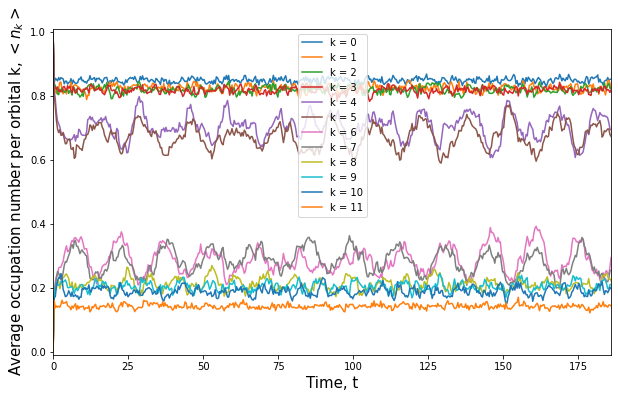

In [776]:
plot_occupation_time(dic_sigma_0_1_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_1',500,0))

[0.8488447775194193,
 0.8248202973154325,
 0.8196168291329866,
 0.8180108100036443,
 0.7041962539376156,
 0.6737618362001119,
 0.2859208176328652,
 0.28066932641865966,
 0.21119469962509277,
 0.20341808047950172,
 0.1879966046046263,
 0.141549667136077]

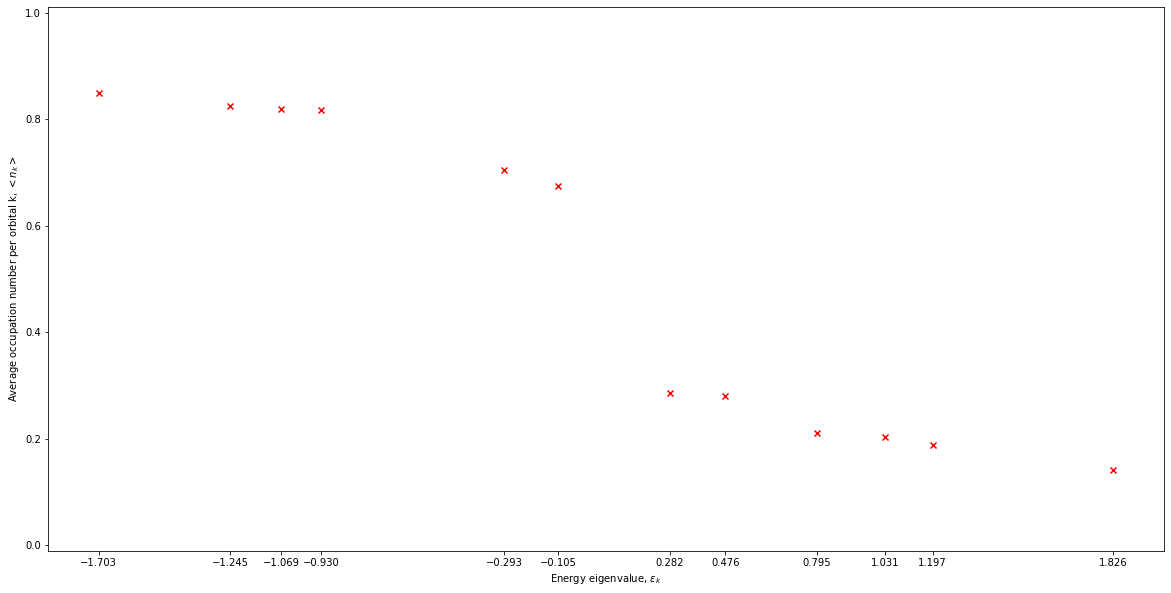

In [635]:
plot_occupation_energy(dic_sigma_0_1_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_1',500,0))

In [777]:
mean_2 = np.array([0.8488447775194193,
 0.8248202973154325,
 0.8196168291329866,
 0.8180108100036443,
 0.7041962539376156,
 0.6737618362001119,
 0.2859208176328652,
 0.28066932641865966,
 0.21119469962509277,
 0.20341808047950172,
 0.1879966046046263,
 0.141549667136077])

In [780]:
popt, pcov = curve_fit(fermi_func, random_energies_2, mean_2)

In [781]:
popt

array([1.45447205, 0.03635822])

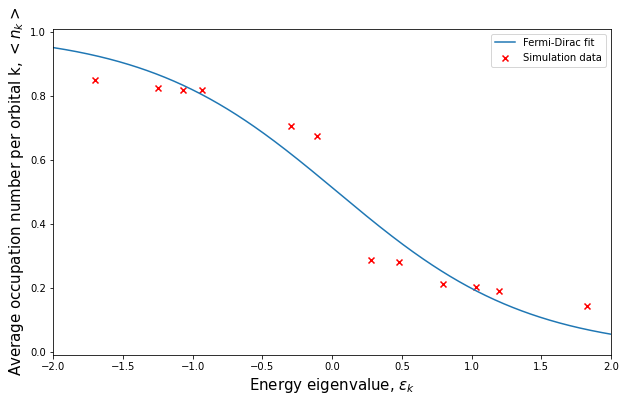

In [782]:
fig, axes = plt.subplots(figsize=((10,6)))
axes.scatter(random_energies_2,mean_2,color='red',marker='x', label='Simulation data')
axes.plot(range, fermi_func(range, *popt), label='Fermi-Dirac fit')
axes.set_ylim((-0.01,1.01))
axes.set_xlim((-2,2))
axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$", fontsize=15)
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$", fontsize=15)
axes.legend()
fig.savefig("occupation_time_fermi_0_1")

In [583]:
start = time.time()
dic_sigma_0_01_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.29756379127502


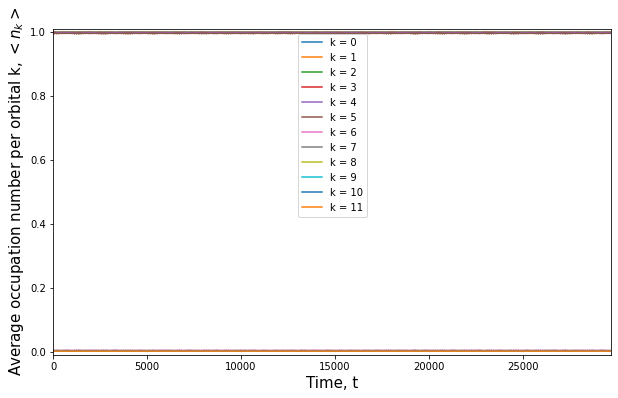

In [783]:
plot_occupation_time(dic_sigma_0_01_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_01',500,0))

In [785]:
mean_3 = np.array([0.9985252298025503,
 0.9980576755474749,
 0.9982538466921825,
 0.9978704803050528,
 0.9976358209928546,
 0.9953611579330583,
 0.0036978813237836103,
 0.0030393348378428293,
 0.0020832194173153675,
 0.001989993175751481,
 0.001986282687799114,
 0.0014990772870612764])

In [786]:
popt, pcov = curve_fit(fermi_func, random_energies_2, mean_3)

In [787]:
popt

array([28.30327944,  0.08474165])

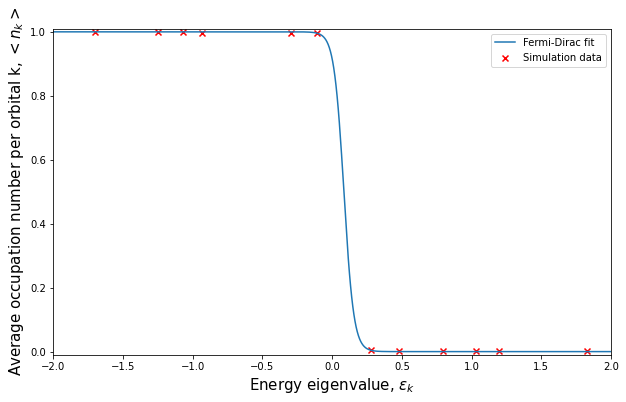

In [788]:
fig, axes = plt.subplots(figsize=((10,6)))
axes.scatter(random_energies_2,mean_3,color='red',marker='x', label='Simulation data')
axes.plot(range, fermi_func(range, *popt), label='Fermi-Dirac fit')
axes.set_ylim((-0.01,1.01))
axes.set_xlim((-2,2))
axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$", fontsize=15)
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$", fontsize=15)
axes.legend()
fig.savefig("occupation_time_fermi_0_01")

In [588]:
start = time.time()
dic_sigma_0_5_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.2775022983551


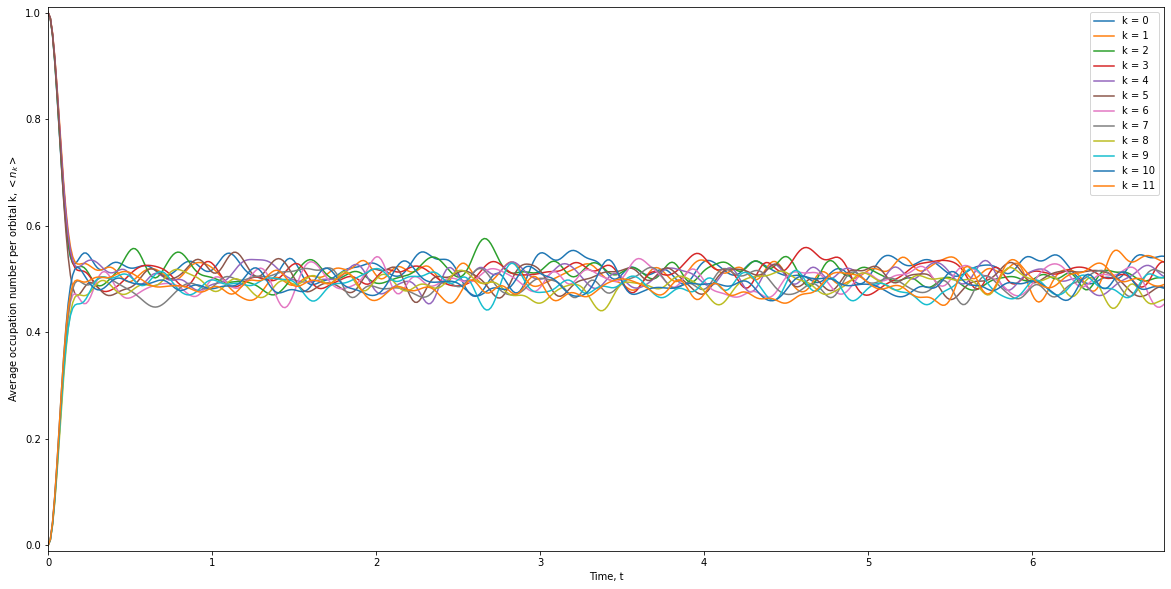

In [589]:
plot_occupation_time(dic_sigma_0_5_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_5',500,0))

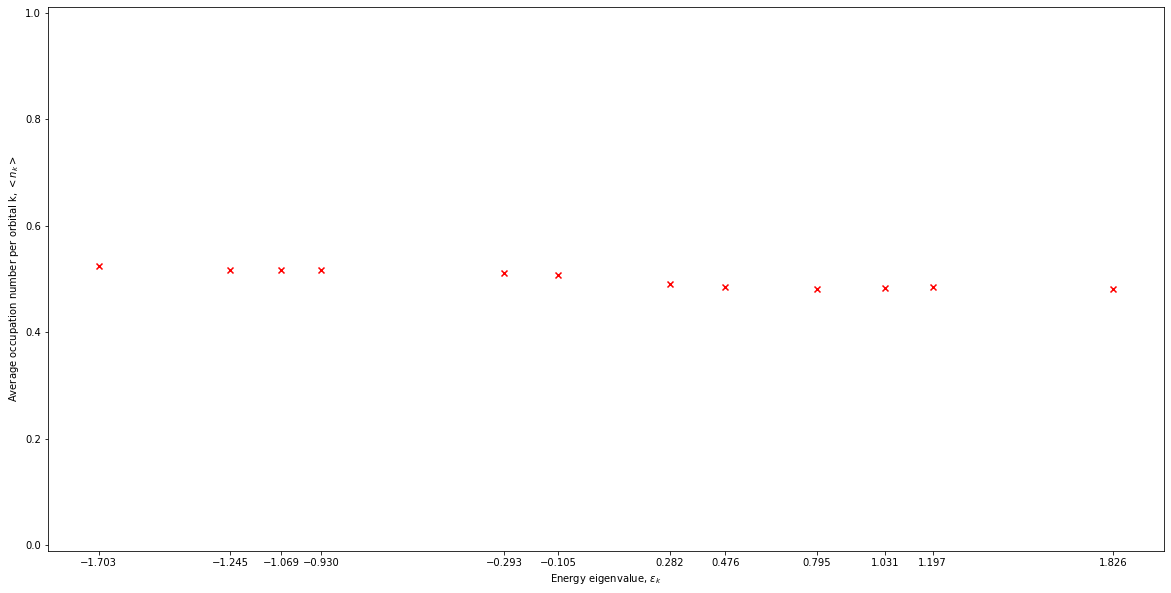

In [590]:
plot_occupation_energy(dic_sigma_0_5_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_5',500,0))

In [593]:
start = time.time()
dic_sigma_0_4_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  63.859130859375


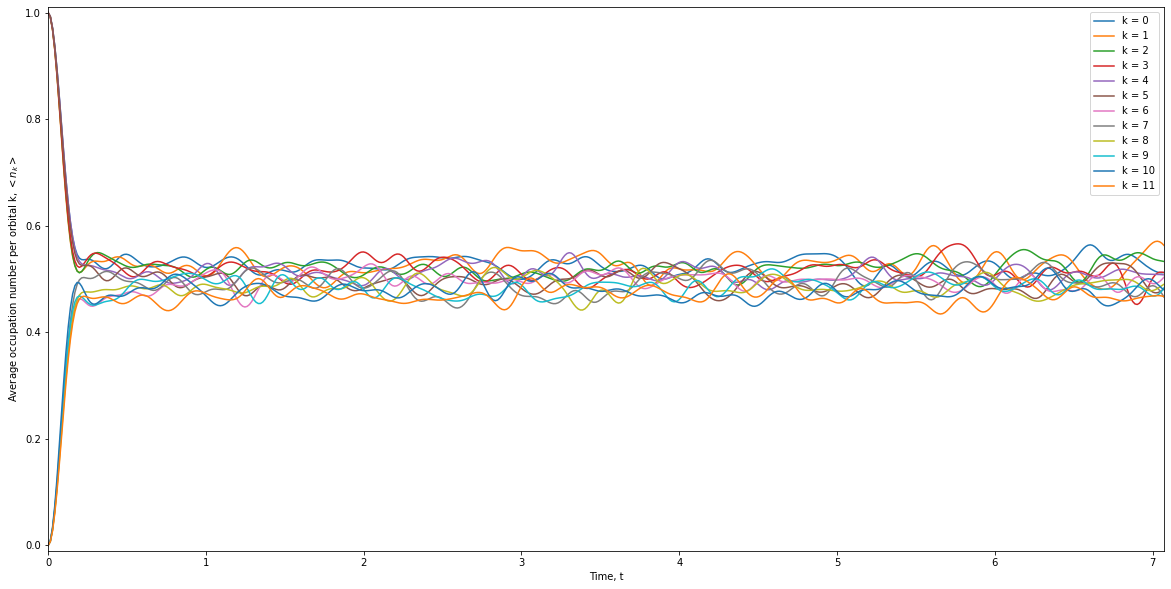

In [594]:
plot_occupation_time(dic_sigma_0_4_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_4',500,0))

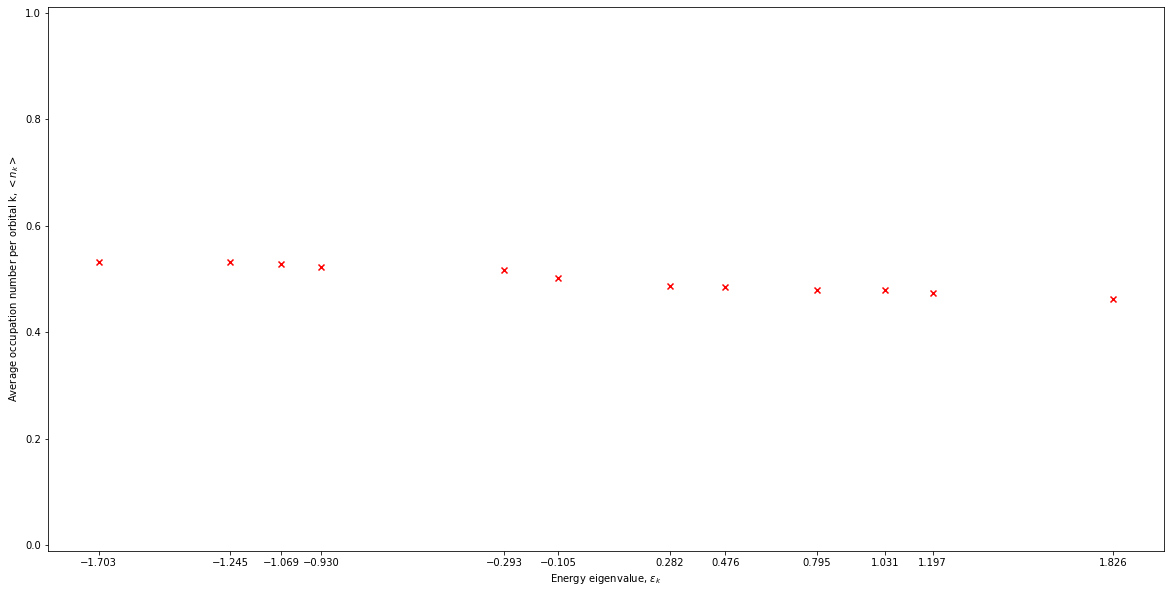

In [595]:
plot_occupation_energy(dic_sigma_0_4_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_4',500,0))

In [598]:
start = time.time()
dic_sigma_0_3_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.03478837013245


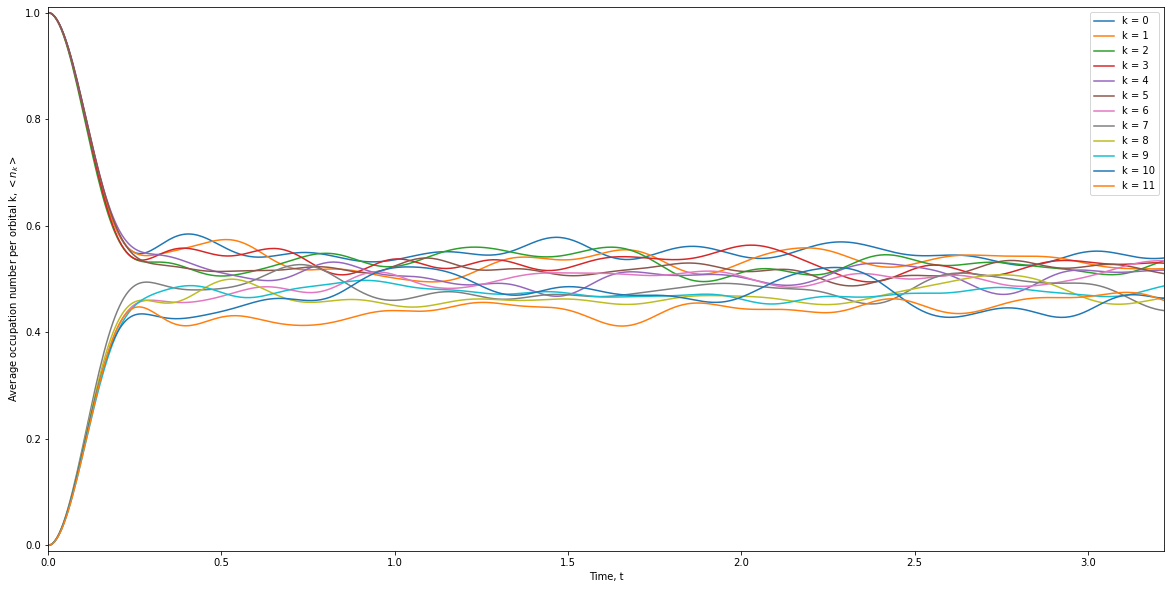

In [599]:
plot_occupation_time(dic_sigma_0_3_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_3',500,0))

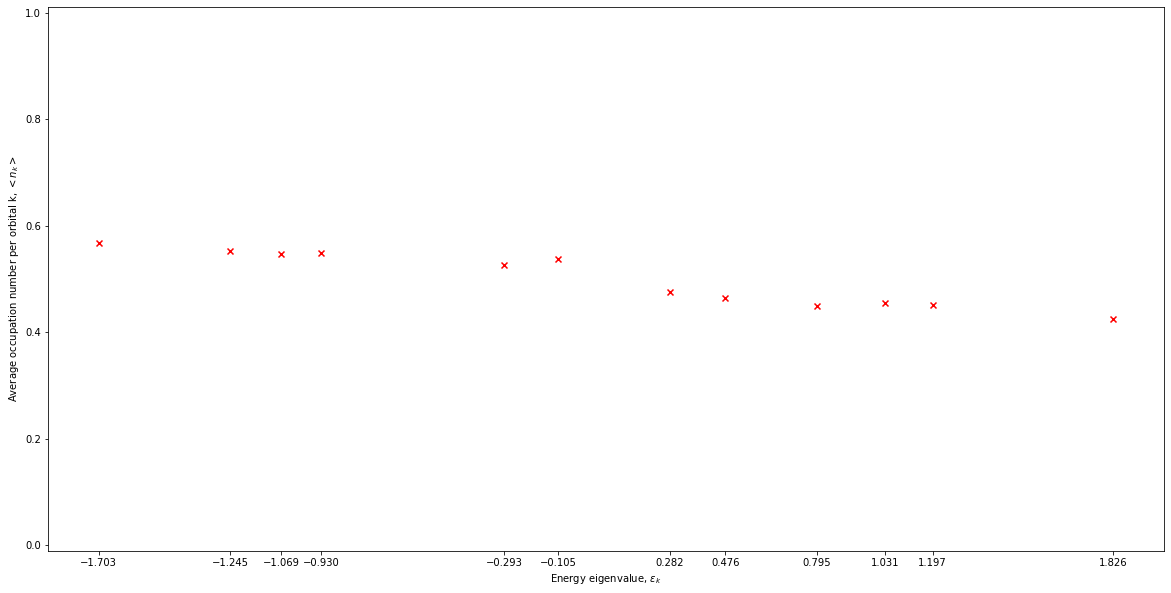

In [600]:
plot_occupation_energy(dic_sigma_0_3_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_3',500,0))

In [603]:
start = time.time()
dic_sigma_0_2_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.2140302658081


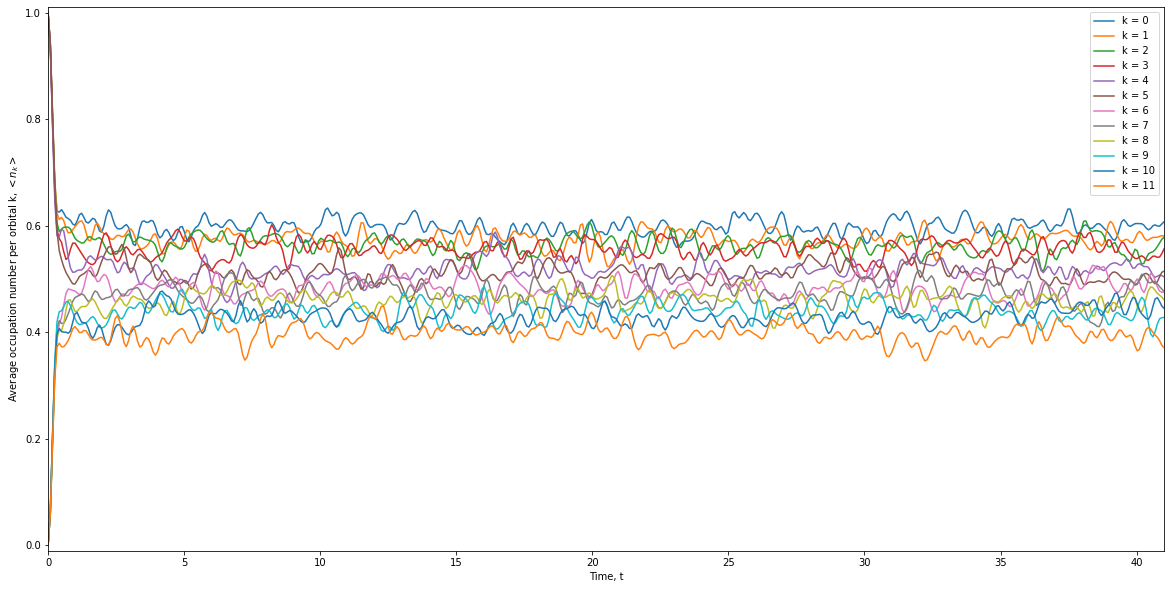

In [604]:
plot_occupation_time(dic_sigma_0_2_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_2',500,0))

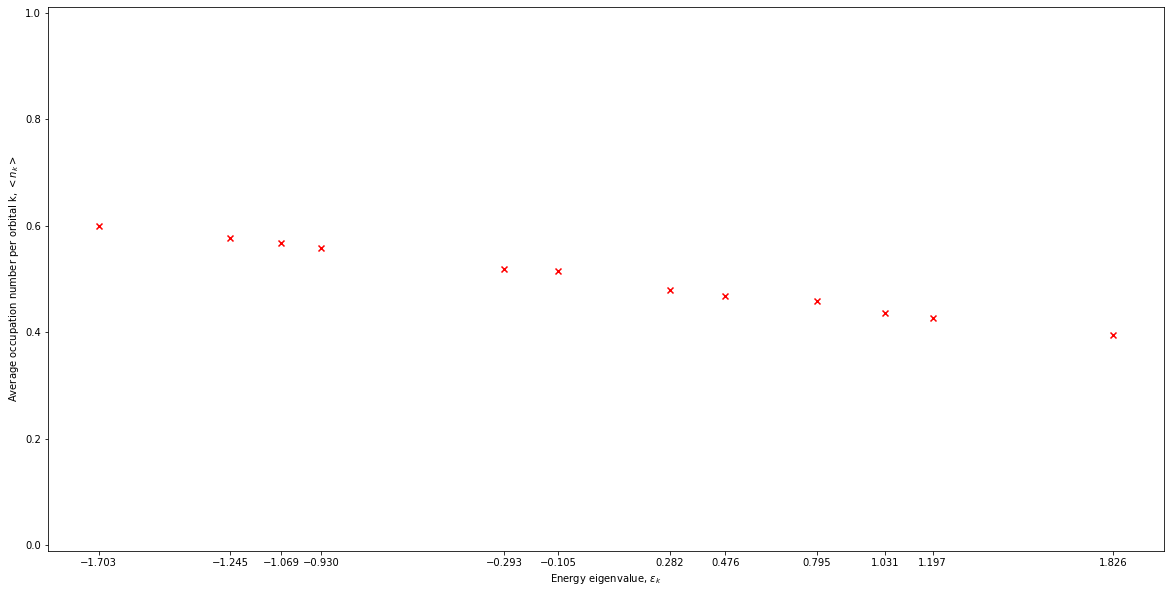

In [605]:
plot_occupation_energy(dic_sigma_0_2_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_2',500,0))

In [608]:
start = time.time()
dic_sigma_0_15_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  63.94944405555725


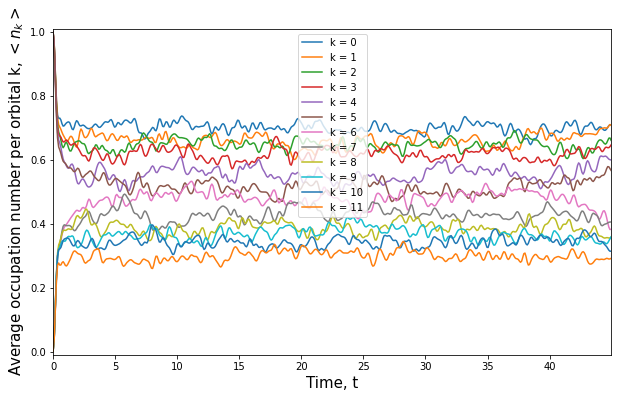

In [790]:
plot_occupation_time(dic_sigma_0_15_runs_500, 0,'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_15',500,0))

In [791]:
mean_4 = [np.mean(dic_sigma_0_15_runs_500['k0']),np.mean(dic_sigma_0_15_runs_500['k1']),np.mean(dic_sigma_0_15_runs_500['k2']),np.mean(dic_sigma_0_15_runs_500['k3']),
         np.mean(dic_sigma_0_15_runs_500['k4']),np.mean(dic_sigma_0_15_runs_500['k5']),np.mean(dic_sigma_0_15_runs_500['k6']),np.mean(dic_sigma_0_15_runs_500['k7']),
         np.mean(dic_sigma_0_15_runs_500['k8']),np.mean(dic_sigma_0_15_runs_500['k9']),np.mean(dic_sigma_0_15_runs_500['k10']),np.mean(dic_sigma_0_15_runs_500['k11'])]

In [792]:
mean_4

[0.7030039948897093,
 0.6628254090364553,
 0.6495149826466878,
 0.6203649381153786,
 0.5594058443511207,
 0.5221177775363868,
 0.47228957439350827,
 0.42390365891925286,
 0.38491956845411773,
 0.3639095556018791,
 0.3408266067737667,
 0.2969180892864239]

In [793]:
popt, pcov = curve_fit(fermi_func, random_energies_2, mean_4)

In [794]:
popt

array([0.53006821, 0.02209858])

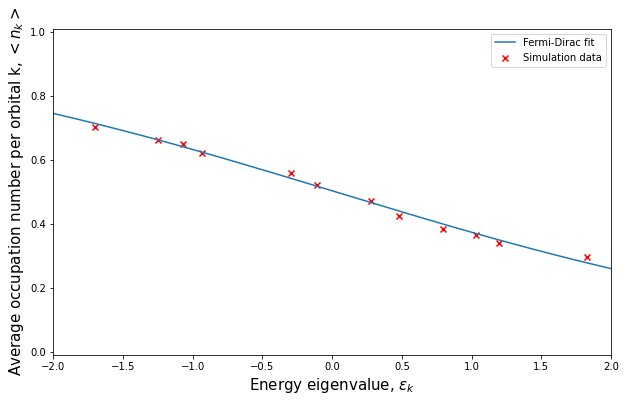

In [795]:
fig, axes = plt.subplots(figsize=((10,6)))
axes.scatter(random_energies_2,mean_4,color='red',marker='x', label='Simulation data')
axes.plot(range, fermi_func(range, *popt), label='Fermi-Dirac fit')
axes.set_ylim((-0.01,1.01))
axes.set_xlim((-2,2))
axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$", fontsize=15)
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$", fontsize=15)
axes.legend()
fig.savefig("occupation_time_fermi_0_15")

In [613]:
start = time.time()
dic_sigma_0_05_runs_500 = run_simulation(500)
print('Runtime: ', time.time()-start)

Runtime:  64.04037141799927


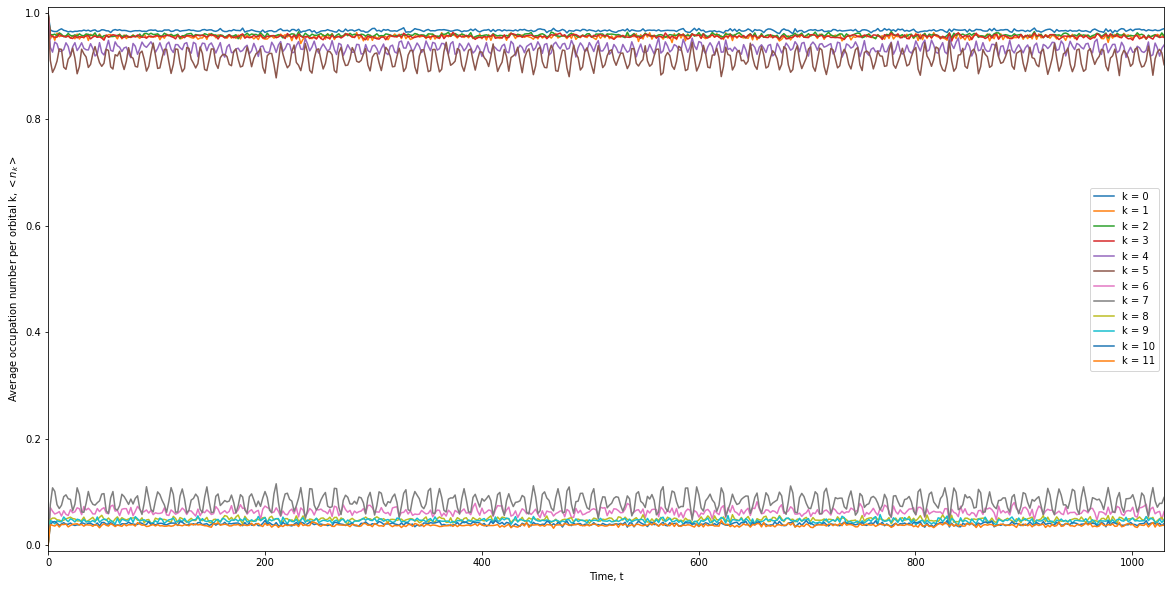

In [614]:
plot_occupation_time(dic_sigma_0_05_runs_500, 0, 'occupation_time_sigma_{}_runs_{}_cutoff_{}'.format('0_05',500,0))

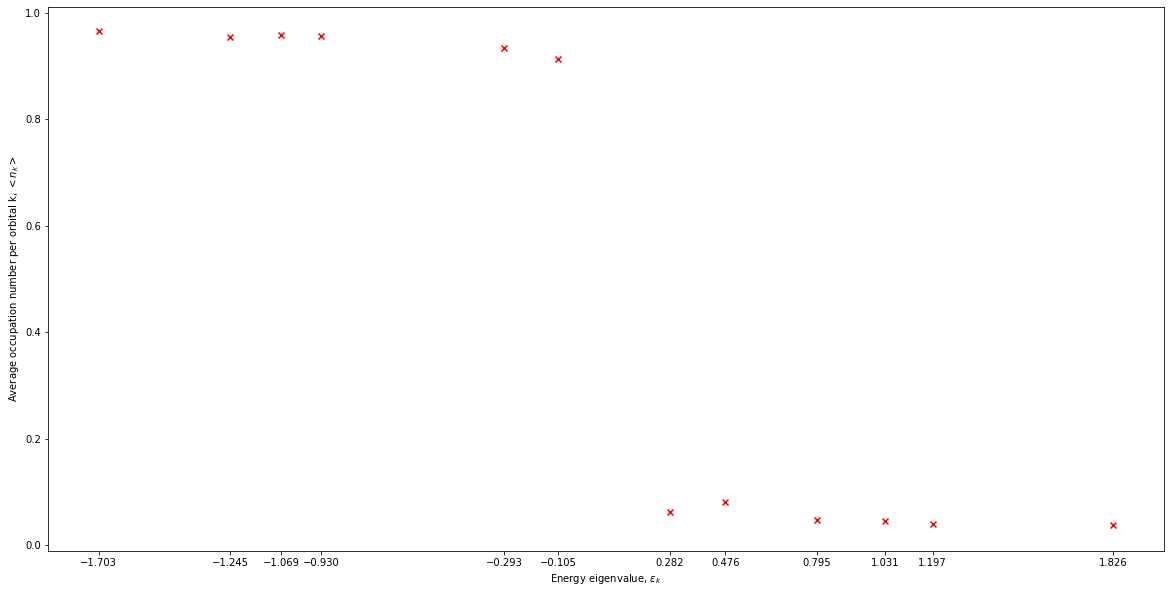

In [615]:
plot_occupation_energy(dic_sigma_0_05_runs_500, 0, 'occupation_energy_sigma_{}_runs_{}_cutoff_{}'.format('0_05',500,0))